# Classification - Etape 3 - Evolution des températures selon classification Koppen

# 1. Import des package

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

C:\Users\julie\anaconda3\envs\geo_env\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
df=pd.read_csv('weatherAUS_Imputer.csv')
df.head()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Rain_J-2,Rain_J+2,Rain_J+3,Mois_cos,Mois_sin,clim_méditerranéen,clim_océanique,clim_sec,clim_subtropical,clim_tropical
0,96322,6.2,15.1,0.0,1.80,2.1,20.0,2.0,11.0,81.0,...,1.0,0.0,0.0,-1.0,1.224647e-16,1,0,0,0,0
1,96323,5.3,15.9,0.0,1.40,8.0,30.0,6.0,13.0,71.0,...,0.0,0.0,1.0,-1.0,1.224647e-16,1,0,0,0,0
2,96324,9.8,15.4,0.0,2.80,0.9,30.0,9.0,9.0,56.0,...,0.0,1.0,1.0,-1.0,1.224647e-16,1,0,0,0,0
3,96325,11.3,15.7,8.1,1.64,1.5,52.0,15.0,22.0,62.0,...,0.0,1.0,1.0,-1.0,1.224647e-16,1,0,0,0,0
4,96326,7.6,11.2,16.2,4.60,1.1,46.0,17.0,13.0,83.0,...,0.0,1.0,1.0,-1.0,1.224647e-16,1,0,0,0,0


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

# 2. Création d'un dataframe pour classification à partir de l'évolution des températures

In [4]:
df_class=df[['Date','MinTemp','MaxTemp','Location','Climat_Koppen']]

## Création du colonne de température moyenne

In [5]:
df_class['AvTemp']=(df_class['MinTemp']+df_class['MaxTemp'])/2

C:\Users\julie\AppData\Local\Temp\ipykernel_28616\3498255532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_class['AvTemp']=(df_class['MinTemp']+df_class['MaxTemp'])/2


In [6]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145455 entries, 0 to 145454
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145455 non-null  datetime64[ns]
 1   MinTemp        145455 non-null  float64       
 2   MaxTemp        145455 non-null  float64       
 3   Location       145455 non-null  object        
 4   Climat_Koppen  145455 non-null  object        
 5   AvTemp         145455 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 6.7+ MB


## Récupération de la liste des villes

In [7]:
locations= df_class.Location.drop_duplicates().to_list()

## Filtre sur la plus grande période contenant autant de données pour chacune des villes.

In [8]:

mask = (df_class['Date'] >= '2014-01-01') & (df_class['Date'] <= '2017-06-22')
filtered_df_class=df_class.loc[mask]
filtered_df_class.head()

,Date,MinTemp,MaxTemp,Location,Climat_Koppen,AvTemp
1919,2014-01-01,22.0,33.0,Adelaide,Csa,27.50
1920,2014-01-02,16.9,22.7,Adelaide,Csa,19.80
1921,2014-01-03,15.2,22.6,Adelaide,Csa,18.90
1922,2014-01-04,14.8,22.8,Adelaide,Csa,18.80
1923,2014-01-05,16.0,21.7,Adelaide,Csa,18.85


In [9]:
filtered_df_class.tail()

,Date,MinTemp,MaxTemp,Location,Climat_Koppen,AvTemp
145450,2017-06-18,8.3,19.0,Woomera,Bwh,13.65
145451,2017-06-19,5.5,19.5,Woomera,Bwh,12.50
145452,2017-06-20,5.6,19.7,Woomera,Bwh,12.65
145453,2017-06-21,5.8,19.9,Woomera,Bwh,12.85
145454,2017-06-22,7.8,19.0,Woomera,Bwh,13.40


## La 3ème lettre des types de Climat Koppen correspond à la caractérisation des températures
### Création d'une nouvelle colonne correspondant à cette lettre
#

In [10]:
filtered_df_class['Climat_Koppen_3L']=filtered_df_class['Climat_Koppen'].str[2]
filtered_df_class

C:\Users\julie\AppData\Local\Temp\ipykernel_28616\3190861790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_class['Climat_Koppen_3L']=filtered_df_class['Climat_Koppen'].str[2]


,Date,MinTemp,MaxTemp,Location,Climat_Koppen,AvTemp,Climat_Koppen_3L
1919,2014-01-01,22.0,33.0,Adelaide,Csa,27.50,a
1920,2014-01-02,16.9,22.7,Adelaide,Csa,19.80,a
1921,2014-01-03,15.2,22.6,Adelaide,Csa,18.90,a
1922,2014-01-04,14.8,22.8,Adelaide,Csa,18.80,a
1923,2014-01-05,16.0,21.7,Adelaide,Csa,18.85,a
...,...,...,...,...,...,...,...
145450,2017-06-18,8.3,19.0,Woomera,Bwh,13.65,h
145451,2017-06-19,5.5,19.5,Woomera,Bwh,12.50,h
145452,2017-06-20,5.6,19.7,Woomera,Bwh,12.65,h
145453,2017-06-21,5.8,19.9,Woomera,Bwh,12.85,h


## Visualisation de la distribution des régimes de températures

C:\Users\julie\anaconda3\envs\geo_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


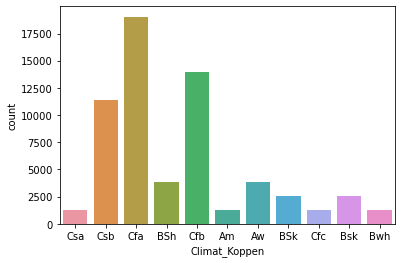

In [11]:
sns.countplot(filtered_df_class.Climat_Koppen);

## Récupération des types ce Climat Koppen associés à la température

In [12]:
labels=filtered_df_class.Climat_Koppen_3L.drop_duplicates().to_list()
labels

['a', 'b', 'h', nan, 'k', 'c']

## Encodage des lettres // affectation d'un code spécifique au "Nan"

In [13]:
le=LabelEncoder()
le.fit(labels)
labels=np.array(le.transform(labels))
labels

array([0, 1, 3, 5, 4, 2])

## Création du dataset pour le clustering des times series de températures moyennes

In [14]:
x = np.array(filtered_df_class.AvTemp)
x

array([27.5 , 19.8 , 18.9 , ..., 12.65, 12.85, 13.4 ])

In [15]:
len(x)

62181

In [16]:
x = x.reshape(49,1269)
x

array([[27.5       , 19.8       , 18.9       , ..., 12.        ,
        11.85      , 12.05      ],
       [18.875     , 19.75      , 16.85      , ..., 14.19583333,
        14.11666667, 13.5125    ],
       [19.7       , 22.2       , 24.75      , ...,  8.05      ,
         8.2       ,  7.1       ],
       ...,
       [17.        , 16.85      , 14.85      , ..., 14.45      ,
        14.55      , 14.5       ],
       [21.75      , 27.35      , 22.        , ..., 15.35      ,
        12.85      , 14.05      ],
       [37.4       , 33.9       , 24.        , ..., 12.65      ,
        12.85      , 13.4       ]])

In [17]:
len(x[0])

1269

In [18]:
x_train = x.reshape((x.shape[0], x.shape[1], 1))
x_train

array([[[27.5       ],
        [19.8       ],
        [18.9       ],
        ...,
        [12.        ],
        [11.85      ],
        [12.05      ]],

       [[18.875     ],
        [19.75      ],
        [16.85      ],
        ...,
        [14.19583333],
        [14.11666667],
        [13.5125    ]],

       [[19.7       ],
        [22.2       ],
        [24.75      ],
        ...,
        [ 8.05      ],
        [ 8.2       ],
        [ 7.1       ]],

       ...,

       [[17.        ],
        [16.85      ],
        [14.85      ],
        ...,
        [14.45      ],
        [14.55      ],
        [14.5       ]],

       [[21.75      ],
        [27.35      ],
        [22.        ],
        ...,
        [15.35      ],
        [12.85      ],
        [14.05      ]],

       [[37.4       ],
        [33.9       ],
        [24.        ],
        ...,
        [12.65      ],
        [12.85      ],
        [13.4       ]]])

In [19]:
x_train.shape

(49, 1269, 1)

# 3. Utilisation de tslearn et de l'algoritme TimeSeriesKmeans / Metric dtw

In [20]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
sz = x_train.shape[1]
num_classes=2*labels.shape[0]

## Définition des bornes min max températures pour graphique des clusters

In [21]:
max_y=filtered_df_class['AvTemp'].max()
min_y=filtered_df_class['AvTemp'].min()

## Timeseries clustering / Metric=dtw

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1790.212 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    9.7s finished


1169.901 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    8.7s finished


1169.901 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1798.546 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   10.2s finished


1188.471 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    9.9s finished


1188.471 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1866.743 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    9.5s finished


1249.631 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    9.4s finished


1249.631 --> 
Init 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1763.069 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   26.8s finished


1163.723 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   17.0s finished


1163.723 --> 
Init 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1742.745 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    9.6s finished


1154.086 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    9.3s finished


1154.086 --> 
Init 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1856.182 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    9.0s finished


1204.504 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    8.9s finished


1204.504 --> 
Init 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1958.657 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   10.5s finished


1276.653 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   16.4s finished


1276.653 --> 
Init 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1819.215 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    8.8s finished


1165.469 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    8.9s finished


1165.469 --> 
Init 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1867.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    9.3s finished


1210.269 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    8.6s finished


1210.269 --> 
Init 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1811.848 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    9.9s finished


1160.129 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    8.9s finished


1160.129 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:    8.9s finished


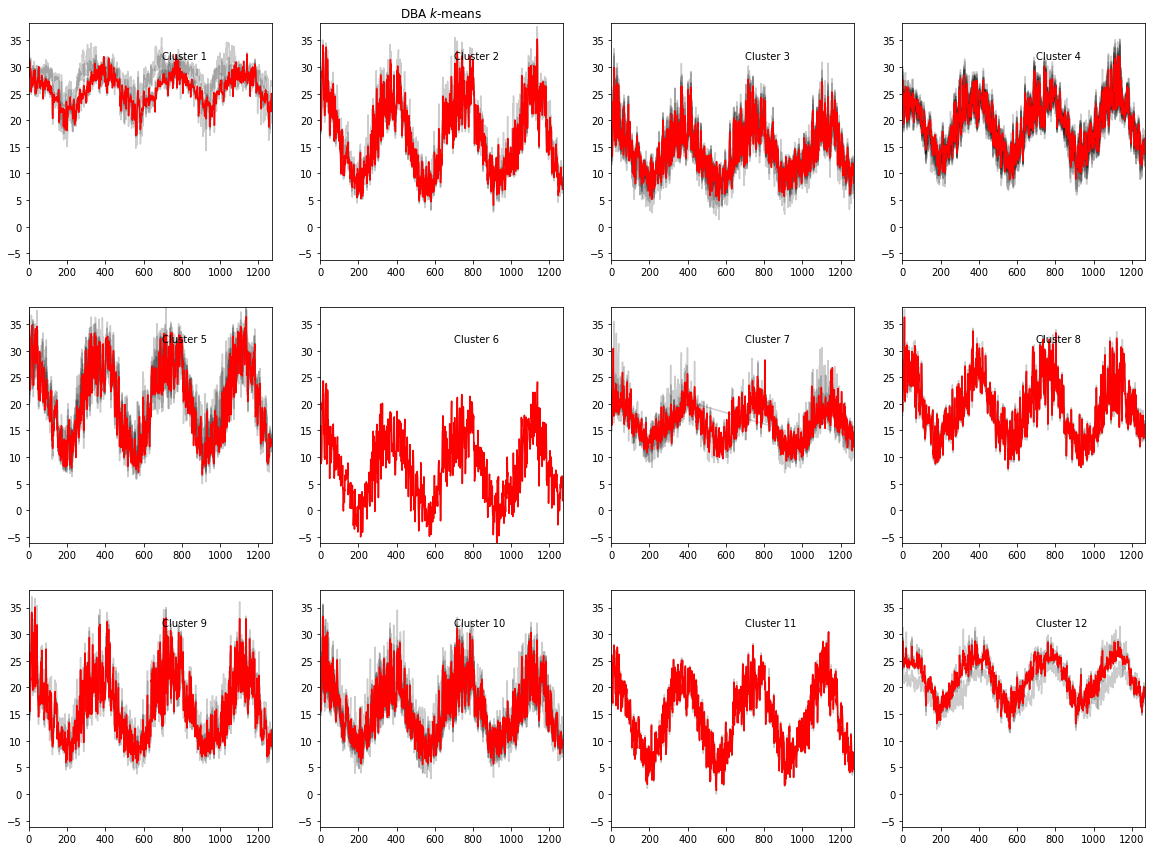

In [22]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=num_classes,
                          n_init=10,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=100,
                          random_state=seed)
y_pred_dba = dba_km.fit_predict(x_train)

plt.figure(figsize=(20,20))

for yi in range(num_classes):
    plt.subplot(4, 4, 1 + yi)
    for xx in x_train[y_pred_dba == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(min_y, max_y)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")



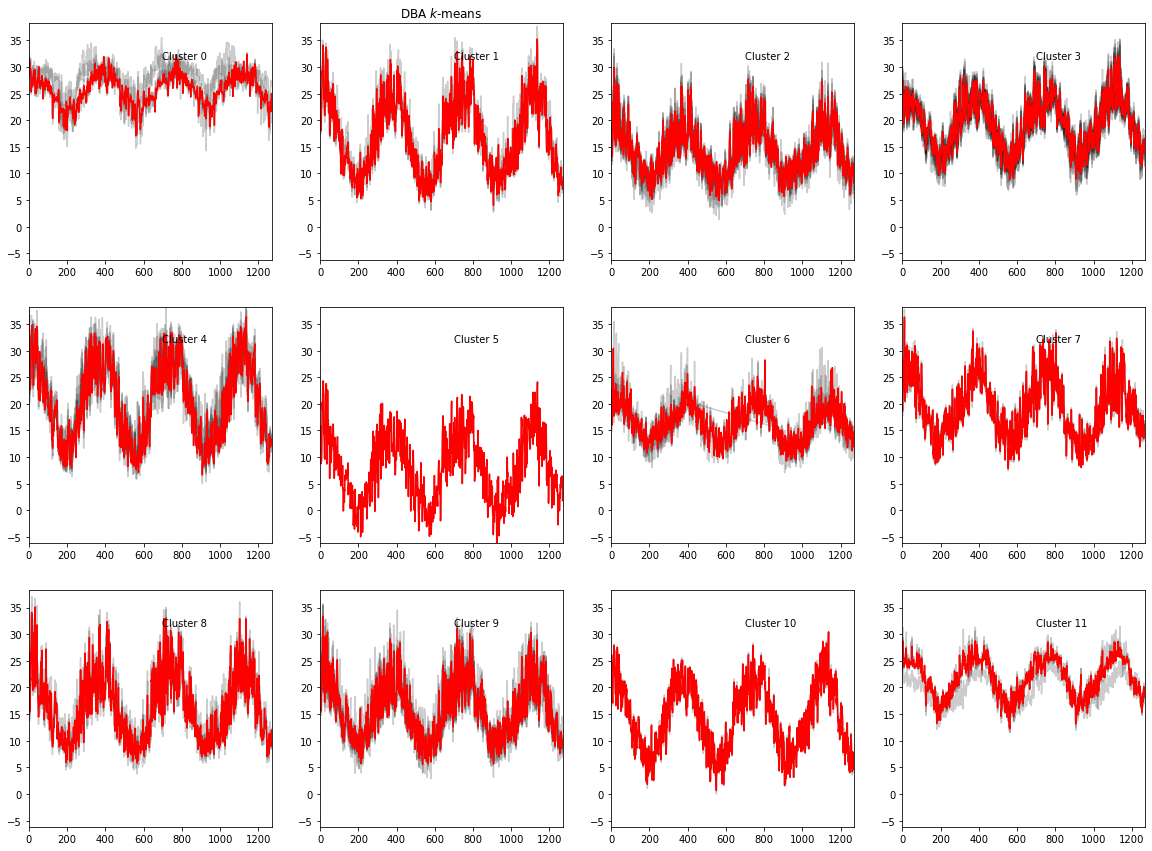

In [23]:
plt.figure(figsize=(20,20))

for yi in range(num_classes):
    plt.subplot(4, 4, 1 + yi)
    for xx in x_train[y_pred_dba == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(min_y, max_y)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")


# 4. Synthèse des résultats 

In [24]:
#Synthèse des résultats 
results=pd.DataFrame({'Location':locations,'Clusters':y_pred_dba})
climatsaus = pd.read_csv("climatsAUS_v2.csv",sep=";")
results = pd.merge(results, climatsaus, how='left', left_on="Location",right_on="Location")

In [25]:
results['Climat_Koppen']=results['Climat_Koppen'].str[2]

In [26]:
results

,Location,Clusters,Climat_Koppen
0,Adelaide,8,a
1,Albany,6,b
2,Albury,1,a
3,AliceSprings,4,h
4,BadgerysCreek,3,a
5,Ballarat,2,b
6,Bendigo,9,b
7,Brisbane,11,a
8,Cairns,0,NaN
9,Canberra,10,b


## Encodage des lettres // affectation d'un code spécifique au "Nan"

In [27]:

le=LabelEncoder()
le.fit(results['Climat_Koppen'])
results['Climat_Koppen_enc']=np.array(le.transform(results['Climat_Koppen']))
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Location           49 non-null     object
 1   Clusters           49 non-null     int64 
 2   Climat_Koppen      45 non-null     object
 3   Climat_Koppen_enc  49 non-null     int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 1.7+ KB


In [28]:
# la TimeKmeans avec Dynamic Time Warping Distance Metric isole davantage certains climats (mousson par exemple)
# nous utiliserons cette méthode
#
table_dba = pd.crosstab(results['Climat_Koppen_enc'].astype(str), results['Clusters'].astype(str))

In [29]:
table_dba

Clusters,0,1,10,11,2,3,4,5,6,7,8,9
Climat_Koppen_enc,,,,,,,,,,,,
0,0,2,0,3,0,9,1,0,0,0,1,0
1,0,0,2,0,6,1,0,0,4,3,0,4
2,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,4,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,2,1
5,4,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# Visulations des climats pour chacune des villes
#
aus_town_gps = pd.read_csv("aus_town_gps.csv",sep=",")
aus_town_gps
results = pd.merge(results, aus_town_gps, how='left', left_on="Location",right_on="Location")

In [31]:
results['Clusters']=results['Clusters'].astype(str)
results['Climat_Koppen_enc']=results['Climat_Koppen_enc'].astype(str)

# 5. Visualisations des climats pour chacune des villes

In [32]:
import geopandas as gpd
from shapely.geometry import Point

Contour_Aus = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Contour_Aus = Contour_Aus[Contour_Aus["name"] == "Australia"]

geometry = [Point(xy) for xy in zip(results['Longitude'], results['Latitude'])]
geo_df = gpd.GeoDataFrame(results, geometry=geometry)

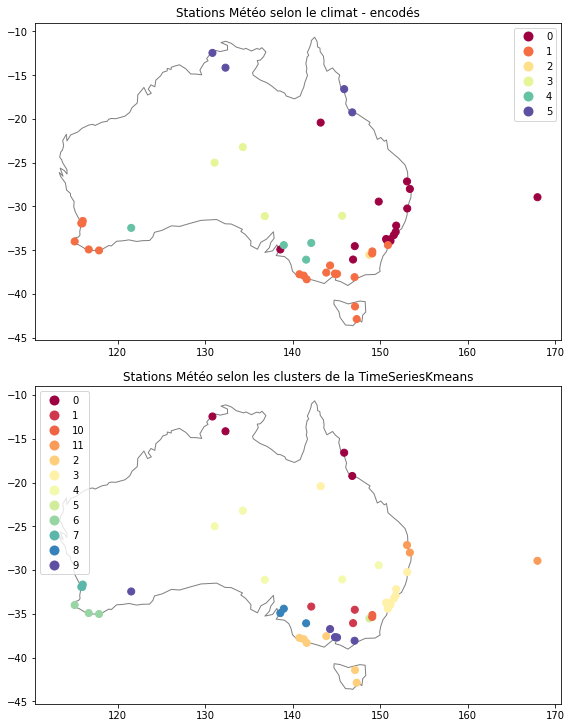

In [33]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(2, 1, wspace=0.07)

ax=subfigs[0].subplots(1, 1)
Contour_Aus.plot(ax=ax,color="None",edgecolor="Grey")  
ax.title.set_text('Stations Météo selon le climat - encodés')
geo_df.plot(ax=ax,markersize=50, cmap='Spectral', column="Climat_Koppen_enc",legend=True);

ax1=subfigs[1].subplots(1, 1)
Contour_Aus.plot(ax=ax1,color="None",edgecolor="Grey")  
ax1.title.set_text('Stations Météo selon les clusters de la TimeSeriesKmeans')
geo_df.plot(ax=ax1,markersize=50, cmap='Spectral', column="Clusters",legend=True);

In [34]:
# Réaffectation des labels des clusters pour matcher avec l'échelle des couleurs de la première carte
results["Clusters_labels"]=results['Clusters'].map({"1":"00",
                                                     "3":"01",
                                                     "4":"02",
                                                    "8":"03",
                                                    "11":"04",
                                                    "9":"05",
                                                    "2":"06",
                                                    "6":"07",
                                                    "7":"08",
                                                    "10":"09",
                                                    "5":"10",
                                                    "0":"11"})
results["Climat_Koppen_T"]=results['Climat_Koppen_enc'].map({"0":"a",
                                                     "1":"b",
                                                     "2":"c",
                                                    "3":"h",
                                                    "4":"k",
                                                    "5":"Non Applicable"})

In [35]:
table_dba = pd.crosstab(results['Climat_Koppen_T'].astype(str), results['Clusters_labels'].astype(str))
table_dba

Clusters_labels,00,01,02,03,04,05,06,07,08,09,10,11
Climat_Koppen_T,,,,,,,,,,,,
Non Applicable,0,0,0,0,0,0,0,0,0,0,0,4
a,2,9,1,1,3,0,0,0,0,0,0,0
b,0,1,0,0,0,4,6,4,3,2,0,0
c,0,0,0,0,0,0,0,0,0,0,1,0
h,0,0,4,0,0,0,0,0,0,0,0,0
k,1,0,0,2,0,1,0,0,0,0,0,0


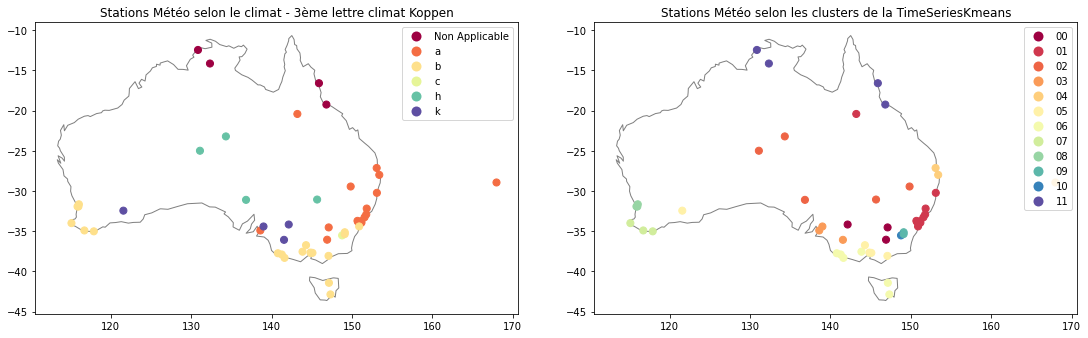

In [36]:
Contour_Aus = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Contour_Aus = Contour_Aus[Contour_Aus["name"] == "Australia"]

fig = plt.figure(constrained_layout=True, figsize=(15, 15))
subfigs = fig.subfigures(1, 2, wspace=0.07)

ax=subfigs[0].subplots(1, 1)
Contour_Aus.plot(ax=ax,color="None",edgecolor="Grey")  
ax.title.set_text('Stations Météo selon le climat - 3ème lettre climat Koppen')
geo_df.plot(ax=ax,markersize=50, cmap='Spectral', column="Climat_Koppen_T",legend=True);

ax1=subfigs[1].subplots(1, 1)
Contour_Aus.plot(ax=ax1,color="None",edgecolor="Grey")  
ax1.title.set_text('Stations Météo selon les clusters de la TimeSeriesKmeans')
geo_df.plot(ax=ax1,markersize=50, cmap='Spectral', column="Clusters_labels",legend=True);

In [37]:
results[['Location','Climat_Koppen','Clusters_labels']].to_csv("tkmeans_3L.csv")